In [2]:
import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt


import numpy as np
import pandas as pd


import IPython.display as ipd
from IPython.display import Audio


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization


In [3]:
path = "TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/"

In [4]:
directory_list = os.listdir(path)

In [5]:

tess_directory_list = os.listdir(path)
file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(path+ dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(path + dir + '/' + file)       

        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
df = pd.concat([emotion_df, path_df], axis=1)
df.head()



,Emotions,Path
0,angry,TESS Toronto emotional speech set data/TESS To...
1,angry,TESS Toronto emotional speech set data/TESS To...
2,angry,TESS Toronto emotional speech set data/TESS To...
3,angry,TESS Toronto emotional speech set data/TESS To...
4,angry,TESS Toronto emotional speech set data/TESS To...


In [6]:
df['Emotions'].value_counts()

Emotions
angry       400
disgust     400
fear        400
happy       400
neutral     400
surprise    400
sad         400
Name: count, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Emotions  2800 non-null   object
 1   Path      2800 non-null   object
dtypes: object(2)
memory usage: 43.9+ KB


c:\Users\90537\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\90537\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\90537\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 0, 'Emotions')

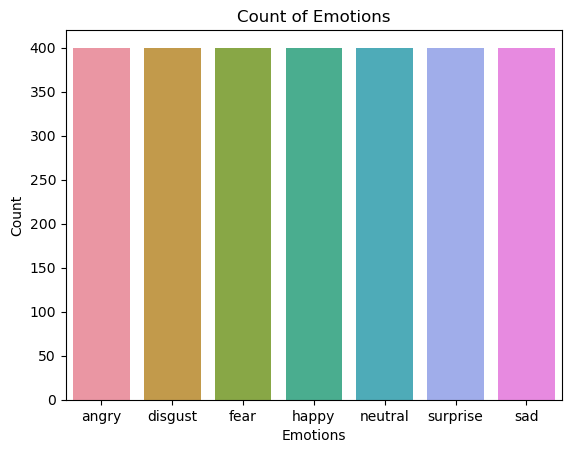

In [8]:
emotion_counts = df['Emotions'].value_counts()
sns.set_palette('spring')
plt.title('Count of Emotions')
sns.barplot(x=emotion_counts.index, y=emotion_counts.values)
plt.ylabel('Count')
plt.xlabel('Emotions')

In [9]:
data_array, sample_rate = librosa.load(df['Path'].iloc[0])
sample_rate

22050

In [10]:
ipd.Audio(data_array,rate=sample_rate)

Text(0.5, 1.0, 'Mel Spectrogram ')

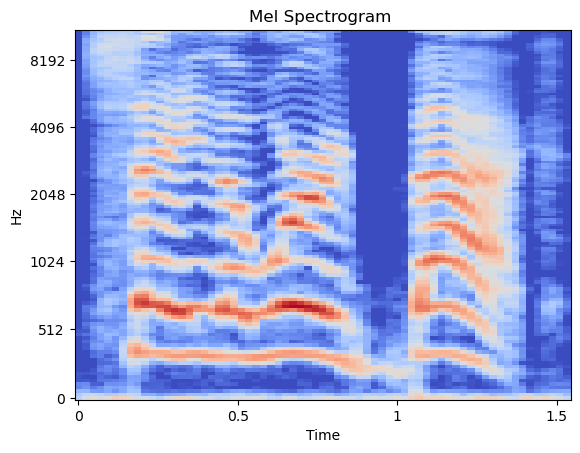

In [11]:
spectrogram = librosa.feature.melspectrogram(y=data_array, sr=sample_rate, n_mels=128,fmax=5000) 
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sample_rate, x_axis='time')
plt.title('Mel Spectrogram ')

In [12]:
def noise(data):
    noise_amp = 0.045*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data,rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

In [13]:
x = noise(data_array)
ipd.Audio(x, rate=sample_rate)

In [14]:
x = stretch(data_array)
ipd.Audio(x, rate=sample_rate)

In [15]:
x = shift(data_array)
ipd.Audio(x, rate=sample_rate)

In [16]:
x = pitch(data=data_array,sampling_rate=sample_rate)
ipd.Audio(x, rate=sample_rate)

In [17]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr))

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) 

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) 

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) 

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) 
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    stretch_data= stretch(data)
    shift_data = shift(data)
    pitch_data = pitch(data=data,sampling_rate=sample_rate)
    pre_data = np.hstack((noise_data, stretch_data))
    pre_data = np.hstack((shift_data, pitch_data)) 
    res2 = extract_features(pre_data)
    result = np.vstack((result, res2)) 

    
    return result

In [18]:
X, Y = [], []
for path, emotion in zip(df.Path, df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [19]:
len(X), len(Y), df.Path.shape

(5600, 5600, (2800,))

In [20]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.054342,0.538992,0.596808,0.396304,0.364695,0.441099,0.413557,0.373404,0.568095,0.573010,...,0.000105,0.000157,0.000185,0.000133,0.000134,0.000070,0.000038,0.000034,6.250596e-06,angry
1,0.060414,0.583129,0.566677,0.382073,0.359121,0.419674,0.380078,0.409977,0.603718,0.537234,...,0.000093,0.000107,0.000126,0.000111,0.000100,0.000063,0.000047,0.000025,3.535453e-06,angry
2,0.058006,0.635519,0.406851,0.370775,0.404711,0.507197,0.455434,0.395454,0.421722,0.353537,...,0.000115,0.000082,0.000030,0.000011,0.000015,0.000021,0.000019,0.000015,9.260864e-07,angry
3,0.061873,0.532557,0.630521,0.440772,0.371295,0.403117,0.483745,0.425356,0.376744,0.393947,...,0.000083,0.000069,0.000045,0.000018,0.000011,0.000013,0.000014,0.000011,7.352512e-07,angry
4,0.113484,0.524840,0.684483,0.540807,0.336128,0.356515,0.429876,0.339963,0.316307,0.422898,...,0.000358,0.000351,0.000266,0.000088,0.000100,0.000195,0.000147,0.000067,2.281613e-06,angry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5595,0.140670,0.489787,0.474594,0.396141,0.379680,0.399372,0.434289,0.444800,0.489512,0.585988,...,0.003732,0.002680,0.001987,0.002004,0.002977,0.001996,0.000955,0.000283,1.902408e-05,sad
5596,0.042546,0.385398,0.349612,0.262639,0.287279,0.288519,0.390569,0.479451,0.438324,0.552938,...,0.000034,0.000035,0.000055,0.000054,0.000070,0.000047,0.000028,0.000013,1.326075e-06,sad
5597,0.043582,0.369332,0.348613,0.273540,0.267620,0.283837,0.373809,0.473437,0.450815,0.523457,...,0.000026,0.000026,0.000037,0.000041,0.000054,0.000042,0.000034,0.000013,1.274398e-06,sad
5598,0.083065,0.429878,0.466670,0.367582,0.382053,0.366562,0.429441,0.482389,0.481741,0.593381,...,0.000148,0.000161,0.000150,0.000181,0.000181,0.000114,0.000093,0.000046,3.928336e-06,sad


In [21]:
Features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5600 entries, 0 to 5599
Columns: 163 entries, 0 to labels
dtypes: float64(162), object(1)
memory usage: 7.0+ MB


In [22]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [23]:
X

array([[5.43421303e-02, 5.38992465e-01, 5.96807599e-01, ...,
        3.77122196e-05, 3.40238912e-05, 6.25059556e-06],
       [6.04142554e-02, 5.83128631e-01, 5.66676736e-01, ...,
        4.74105182e-05, 2.45788651e-05, 3.53545283e-06],
       [5.80055930e-02, 6.35518610e-01, 4.06851083e-01, ...,
        1.90477622e-05, 1.48493382e-05, 9.26086443e-07],
       ...,
       [4.35815594e-02, 3.69331867e-01, 3.48612577e-01, ...,
        3.40596707e-05, 1.33253543e-05, 1.27439750e-06],
       [8.30648843e-02, 4.29878294e-01, 4.66669708e-01, ...,
        9.30976021e-05, 4.59312942e-05, 3.92833635e-06],
       [9.17426215e-02, 4.30077255e-01, 4.61422056e-01, ...,
        8.47379706e-05, 3.88456028e-05, 3.37005804e-06]])

In [24]:
Y

array(['angry', 'angry', 'angry', ..., 'sad', 'sad', 'sad'], dtype=object)

In [25]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()

In [26]:
Y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [27]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape


((4200, 162), (4200, 7), (1400, 162), (1400, 7))

In [28]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [29]:
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [30]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4200, 162), (4200, 7), (1400, 162), (1400, 7))

In [31]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4200, 162, 1), (4200, 7), (1400, 162, 1), (1400, 7))

In [32]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 1, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 1, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 1, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 1, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=7, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 162, 256)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 162, 256)          327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 162, 256)         0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 162, 128)          163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 162, 128)         0

In [33]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
66/66 [==============================] - 11s 154ms/step - loss: 0.8865 - accuracy: 0.6969 - val_loss: 0.3031 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 2/50
66/66 [==============================] - 10s 149ms/step - loss: 0.3889 - accuracy: 0.8700 - val_loss: 0.2069 - val_accuracy: 0.9336 - lr: 0.0010
Epoch 3/50
66/66 [==============================] - 10s 158ms/step - loss: 0.3231 - accuracy: 0.9014 - val_loss: 0.1555 - val_accuracy: 0.9464 - lr: 0.0010
Epoch 4/50
66/66 [==============================] - 9s 144ms/step - loss: 0.2251 - accuracy: 0.9240 - val_loss: 0.1454 - val_accuracy: 0.9507 - lr: 0.0010
Epoch 5/50
66/66 [==============================] - 10s 148ms/step - loss: 0.2384 - accuracy: 0.9188 - val_loss: 0.1806 - val_accuracy: 0.9486 - lr: 0.0010
Epoch 6/50
66/66 [==============================] - 10s 146ms/step - loss: 0.2307 - accuracy: 0.9238 - val_loss: 0.1496 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 7/50
66/66 [==============================] - 9s 143ms/step

44/44 [==============================] - 1s 18ms/step - loss: 0.0360 - accuracy: 0.9907
Accuracy of our model on test data :  99.07143115997314 %


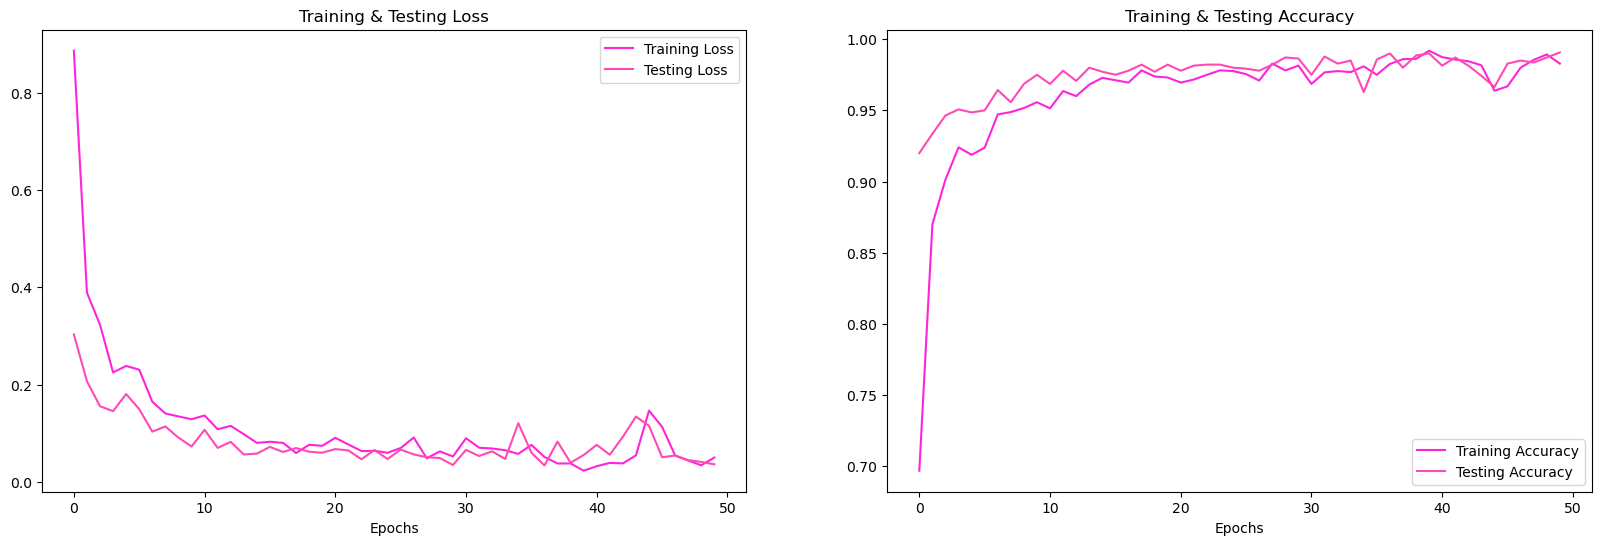

In [34]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [35]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

44/44 [==============================] - 1s 18ms/step


In [36]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()


In [37]:
df.head(20)

,Predicted Labels,Actual Labels
0,neutral,neutral
1,happy,happy
2,surprise,surprise
3,sad,sad
4,angry,angry
5,happy,happy
6,neutral,neutral
7,neutral,neutral
8,disgust,disgust
9,happy,happy


In [56]:
cm_data = confusion_matrix(y_test, y_pred)
print(cm_data)

[[203   2   1   0   0   0   1]
 [  0 187   0   0   0   1   3]
 [  0   0 210   0   0   0   0]
 [  0   0   0 216   0   0   3]
 [  0   1   0   0 184   0   0]
 [  0   0   0   0   0 197   0]
 [  0   1   0   0   0   0 190]]


In [61]:
class_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'surprise', 'sad']

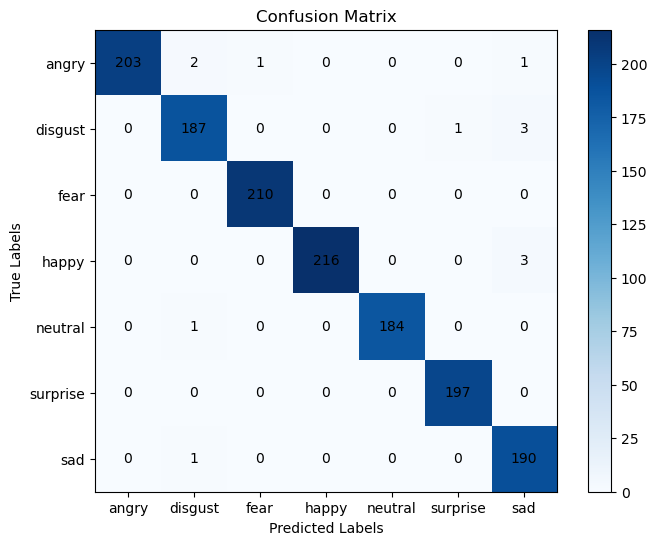

In [73]:
class_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'surprise', 'sad']

# Ensure the confusion matrix is square
assert cm_data.shape[0] == cm_data.shape[1], "Confusion matrix should be square"

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm_data, interpolation='nearest', cmap=plt.cm.Blues)

# Add colorbar
plt.colorbar()

# Set ticks for both axes
tick_marks = np.arange(len(cm_data))
plt.xticks(tick_marks, class_labels)
plt.yticks(tick_marks, class_labels)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Add text annotations
for i in range(len(cm_data)):
    for j in range(len(cm_data)):
        plt.text(j, i, str(cm_data[i, j]), ha='center', va='center', color='black')

plt.show()

In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       1.00      0.98      0.99       207
     disgust       0.98      0.98      0.98       191
        fear       1.00      1.00      1.00       210
       happy       1.00      0.99      0.99       219
     neutral       1.00      0.99      1.00       185
         sad       0.99      1.00      1.00       197
    surprise       0.96      0.99      0.98       191

    accuracy                           0.99      1400
   macro avg       0.99      0.99      0.99      1400
weighted avg       0.99      0.99      0.99      1400

